## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# reading the data from the file
df = pd.read_excel('D:\\Programming\\GUVI PROJECTS CODE\\PROJECT - 3\\Data Preprocessing & Cleaning\\all_city.xlsx')

## Model Selection

In [3]:
X = df.drop('price',axis=1)         # features
y = df['price']                     # target

# splitting the data into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# dictionary of models to be used for training
models = {  
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
}

## Model Training

In [4]:
# Model Training with Cross-validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    results[name] = scores.mean()

print("Cross-Validation Results:")
for model_name, cv_score in results.items():
    print(f"{model_name}: {cv_score:.4f} (R^2)")

Cross-Validation Results:
Linear Regression: 0.7243 (R^2)
Decision Tree: 0.8498 (R^2)
Random Forest: 0.9189 (R^2)
Gradient Boosting: 0.9010 (R^2)


## Model Comparison

In [5]:
# Comparing the models based on evaluation metrics to select the best performing model
models = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor']

lr = LinearRegression().fit(X_train, y_train)
dt = DecisionTreeRegressor().fit(X_train, y_train)
rf = RandomForestRegressor().fit(X_train, y_train)
gb = GradientBoostingRegressor().fit(X_train, y_train)


mae = [mean_absolute_error(y_test, lr.predict(X_test)),
    mean_absolute_error(y_test, dt.predict(X_test)),
    mean_absolute_error(y_test, rf.predict(X_test)),
    mean_absolute_error(y_test, gb.predict(X_test))]

mse = [mean_squared_error(y_test, lr.predict(X_test)),
    mean_squared_error(y_test, dt.predict(X_test)),
    mean_squared_error(y_test, rf.predict(X_test)),
    mean_squared_error(y_test, gb.predict(X_test))]

r2 = [r2_score(y_test, lr.predict(X_test)),
      r2_score(y_test, dt.predict(X_test)),
      r2_score(y_test, rf.predict(X_test)),
      r2_score(y_test, gb.predict(X_test))]

comparison_df = pd.DataFrame({'Model': models, 'MAE': mae, 'MSE': mse, 'R2 Score': r2})
comparison_df


,Model,MAE,MSE,R2 Score
0,Linear Regression,0.170897,0.081699,0.682230
1,Decision Tree Regressor,0.099309,0.037691,0.853403
2,Random Forest Regressor,0.077939,0.023182,0.909835
3,Gradient Boosting Regressor,0.096194,0.031682,0.876773


### After comparing the models, we can see that the Random Forest Regressor has the best performance based on the evaluation metrics.

## Optimization

### Hyperparameter Tuning

In [6]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 201, 10),         # Number of trees in random forest
    'max_depth': [None, 10, 20, 30, 40, 50],        # Maximum number of levels in tree
    'min_samples_split': np.arange(2, 11),          # Minimum number of samples required to split a node
    'min_samples_leaf': np.arange(1, 5),            # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]                      # Method of selecting samples for training each tree
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=20, cv=4, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best Parameters: {'n_estimators': np.int64(120), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(1), 'max_depth': 50, 'bootstrap': True}
Best Score: 0.9161762080850234


In [7]:
best_rf = RandomForestRegressor(n_estimators=120, min_samples_split=4, 
                                 min_samples_leaf=1, max_depth=50, 
                                 bootstrap=True,random_state=42)

best_rf.fit(X_train, y_train)

# Evaluate on test data
y_pred = best_rf.predict(X_test)

print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R-squared: 0.9113738019589291
MSE: 0.02278602573616842


### Feature Engineering

Max Power(bhp)        0.681746
modelYear             0.131566
Registration Year     0.038528
Torque(Nm)            0.023103
variantName           0.019868
centralVariantId      0.018708
Kilometers driven     0.018162
Mileage(kmpl)         0.015186
model                 0.013320
Engine(CC)            0.013156
City                  0.010821
transmission          0.007252
Body type             0.003353
Insurance Validity    0.002471
ownerNo               0.000960
Fuel type             0.000911
Ownership details     0.000889
dtype: float64


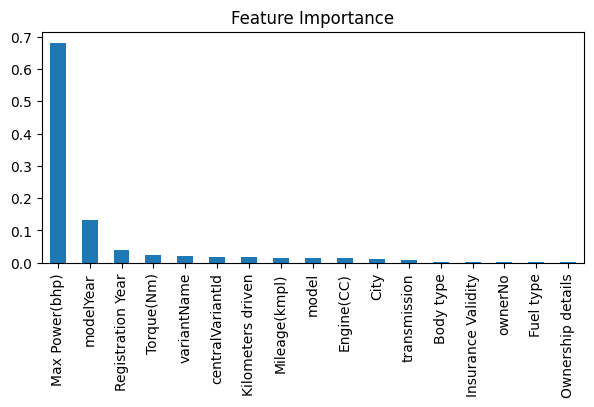

In [8]:
from matplotlib import pyplot as plt
# As we can see Random Forest performs better than others so we choose that model
importances = best_rf.feature_importances_
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)

# Plotting the feature importance
plt.figure(figsize=(7, 3))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

### Regularization

In [9]:
from sklearn.linear_model import Lasso, Ridge

# Lasso Regularization (L1)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Predict and calculate error
lasso_score = cross_val_score(lasso, X_train, y_train, cv=5)
print("Lasso Regression Score:", lasso_score.mean())

# Ridge Regularization (L2)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

# Predict and calculate error
ridge_score = cross_val_score(ridge, X_train, y_train, cv=5)    
print("Ridge Regression Score:", ridge_score.mean())

Lasso Regression Score: 0.5740786011473806
Ridge Regression Score: 0.7242731789072617


## Saving the model into a pickle file

In [21]:
import pickle
with open('D:\\Programming\\GUVI PROJECTS CODE\\PROJECT - 3\\Model\\model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)